# Determine the amount of neutralizing activity directed towards the RBD elicited by infection with Delta variant

## Set up analysis
Import packages

In [1]:
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import lifelines
import sklearn
import scipy.stats

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Use seaborn theme and change font:

In [2]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

Read in config file

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Define results directory

In [4]:
resultsdir = 'results/rbd_depletion_neuts'
os.makedirs(resultsdir, exist_ok=True)

## Read in fracinfect file and plot curves

Read in the neut data for all experiments for this paper, but only select the date(s) that correspond to the RBD depletions experiment. Note that this is only configured to handle one experiment date currently (because the amazingly talented Rachel Eguia ran all these assays on a single date). So for future projects, this might need to be adjusted. 

In [5]:
rbd_depletions_date = [str(i) for i in config['rbd_depletions_date']]
heterologous_depletions_dates = [str(i) for i in config['heterologous_depletions_dates']]
print(f'Getting data from {rbd_depletions_date}')

frac_infect = (pd.read_csv(config['aggregate_fract_infect_csvs'])
               .query('date in @rbd_depletions_date')
               .assign(virus=lambda x: np.where((x['virus']=="mock depletion (D614G spike)") & (x['date'].isin(heterologous_depletions_dates)), 
                                                'heterologous mock depletion (D614G spike)',
                                                x['virus']
                                               )
                      )
               .assign(virus=lambda x: np.where((x['virus']=="Delta RBD antibodies depleted x D614G spike PV"), 
                                                'heterologous Ab depletion (D614G spike)',
                                                x['virus']
                                               )
                      )
              )

fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .assign(spike=lambda x: np.where(x['virus'].str.contains('D614G'), 'D614G', 'Delta'))
    .assign(spike=lambda x: np.where(x['virus'].str.contains('heterologous'), 'Delta dep x D614G PV', x['spike']))
    # get columns of interest
    [['serum', 'virus', 'ic50', 'ic50_bound', 'spike']]
    .assign(NT50=lambda x: 1/x['ic50'])
    .assign(depletion=lambda x: np.where(x['virus'].str.contains('mock'), 'mock depletion', 'RBD antibodies depleted'))
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

display(HTML(fitparams.head().to_html(index=False)))

Getting data from ['2021-11-12', '2021-11-25', '2021-12-12', '2021-12-22', '2022-01-06']


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt


serum,virus,ic50,ic50_bound,spike,NT50,depletion,ic50_is_bound
Delta_10,heterologous mock depletion (D614G spike),0.001134,interpolated,Delta dep x D614G PV,882.157389,mock depletion,False
Delta_10,heterologous Ab depletion (D614G spike),0.040000,lower,Delta dep x D614G PV,25.000000,RBD antibodies depleted,True
Delta_10,mock depletion (D614G spike),0.001088,interpolated,D614G,918.856380,mock depletion,False
Delta_10,RBD antibodies depleted (D614G spike),0.040000,lower,D614G,25.000000,RBD antibodies depleted,True
Delta_10,mock depletion (Delta spike),0.000322,interpolated,Delta,3102.893168,mock depletion,False


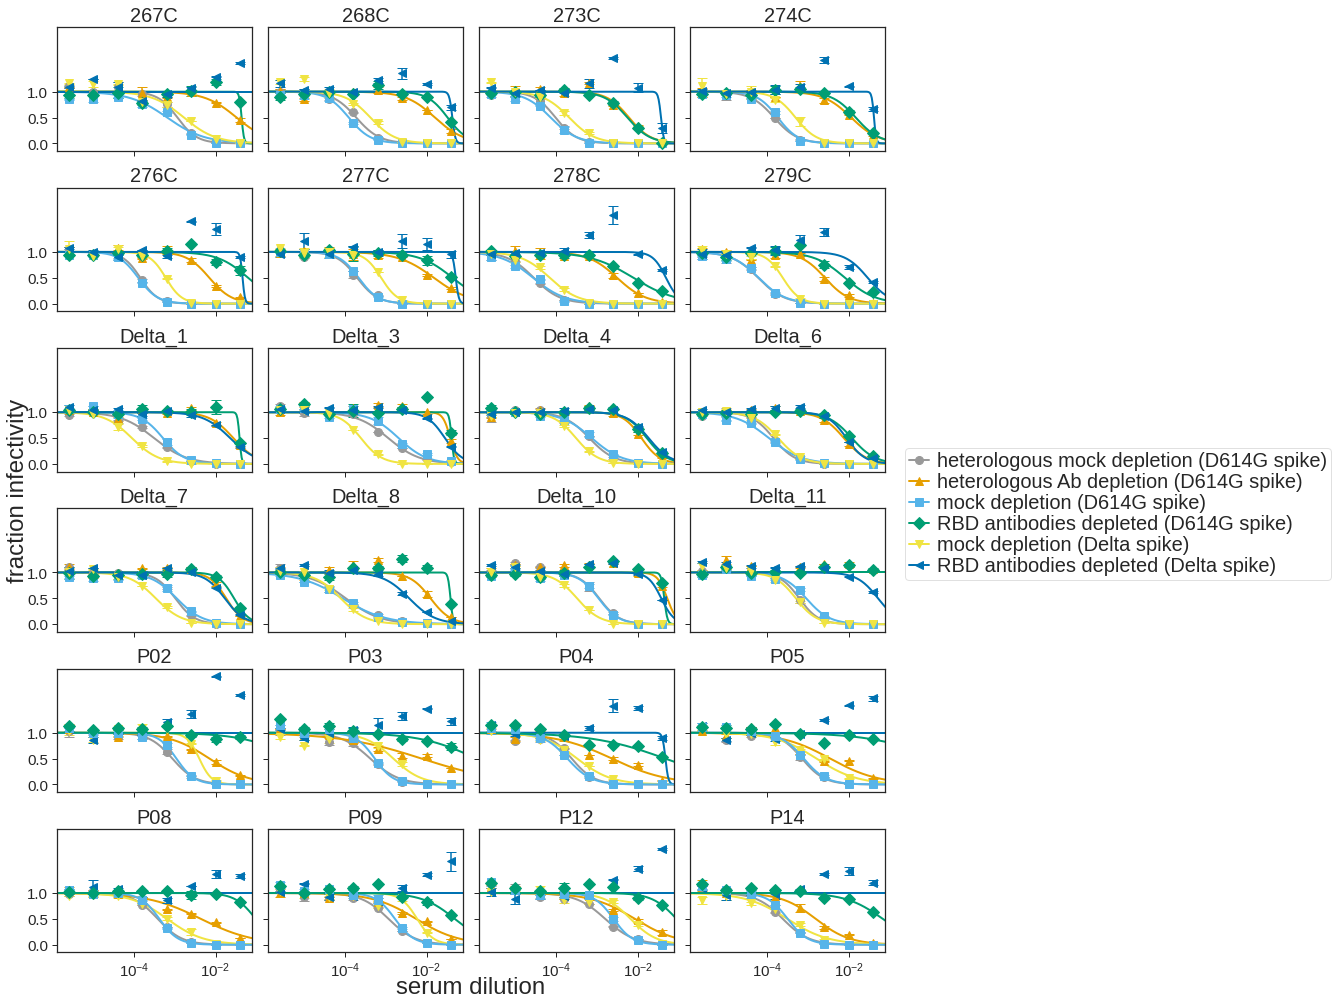

In [6]:
non_neut=[]

fig, axes = fits.plotSera(sera=natsort.natsorted(fitparams.query('serum not in @non_neut')['serum'].unique()),
                          xlabel='serum dilution',
                          ncol=4,
                          widthscale=1,
                          heightscale=1,
                          titlesize=20, labelsize=24, ticksize=15, legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                          max_viruses_per_subplot=8,
                         )

plotfile = PdfPages(f'{resultsdir}/sera_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

In [7]:
# define which sera to exclude from downstream analyses
exclude_sera = []

In [8]:
sample_key = pd.read_csv(config['sample_key_file'])

foldchange = (
    fitparams
    .query('serum not in @exclude_sera')
    .pivot_table(values='ic50', index=['serum','spike'], columns=['depletion'])
    .reset_index()
    .rename(columns={'RBD antibodies depleted': 'post-depletion_ic50', 'mock depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int),
            NT50_pre=lambda x: 1/x['pre-depletion_ic50'],
            NT50_post=lambda x: 1/x['post-depletion_ic50'],
           )
    .merge(fitparams.query('depletion=="RBD antibodies depleted"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    .assign(depletion=lambda x: pd.Categorical(x['depletion'], categories=['mock depletion', 'RBD antibodies depleted'], ordered=True))
    .merge(sample_key, 
           left_on='serum',
           right_on='subject_name',
          )
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
display(HTML(foldchange.head(10).to_html(index=False)))

serum,spike,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,virus,ic50,ic50_bound,NT50,depletion,ic50_is_bound,subject_name,day,sample_type,sample,sorting concentration
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,False,98%,mock depletion (D614G spike),0.000645,interpolated,1550.066341,mock depletion,False,267C,38,Delta breakthrough,267C-day-38,200
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,False,98%,RBD antibodies depleted (D614G spike),0.040000,lower,25.000000,RBD antibodies depleted,True,267C,38,Delta breakthrough,267C-day-38,200
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,True,>98%,mock depletion (D614G spike),0.000645,interpolated,1550.066341,mock depletion,False,267C,38,Delta breakthrough,267C-day-38,200
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,True,>98%,RBD antibodies depleted (D614G spike),0.040000,lower,25.000000,RBD antibodies depleted,True,267C,38,Delta breakthrough,267C-day-38,200
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,True,>98%,mock depletion (D614G spike),0.000645,interpolated,1550.066341,mock depletion,False,267C,38,Delta breakthrough,267C-day-38,200
267C,D614G,0.04,0.000645,62.002654,98,1550.066341,25.0,True,>98%,RBD antibodies depleted (D614G spike),0.040000,lower,25.000000,RBD antibodies depleted,True,267C,38,Delta breakthrough,267C-day-38,200
267C,Delta,0.04,0.001664,24.043240,95,601.081003,25.0,False,95%,mock depletion (Delta spike),0.001664,interpolated,601.081003,mock depletion,False,267C,38,Delta breakthrough,267C-day-38,200
267C,Delta,0.04,0.001664,24.043240,95,601.081003,25.0,False,95%,RBD antibodies depleted (Delta spike),0.040000,lower,25.000000,RBD antibodies depleted,True,267C,38,Delta breakthrough,267C-day-38,200
267C,Delta,0.04,0.001664,24.043240,95,601.081003,25.0,True,>95%,mock depletion (Delta spike),0.001664,interpolated,601.081003,mock depletion,False,267C,38,Delta breakthrough,267C-day-38,200
267C,Delta,0.04,0.001664,24.043240,95,601.081003,25.0,True,>95%,RBD antibodies depleted (Delta spike),0.040000,lower,25.000000,RBD antibodies depleted,True,267C,38,Delta breakthrough,267C-day-38,200


In [9]:
foldchange['sample_type'].unique()

array(['Delta breakthrough', 'primary Delta infection', 'Pfizer'],
      dtype=object)

In [10]:
serum_order = (foldchange
               [['serum', 'spike', 'NT50_pre']]
               .query('spike=="Delta"')
               .sort_values(['NT50_pre'], ascending=True)
               ['serum']
               .unique()
              )

print(len(serum_order))

assert len(serum_order) == len(foldchange['serum'].unique())

24


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 6.75 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/NT50_trackplot.pdf


Writing to results/rbd_depletion_neuts/RBD_depletion_NT50.csv


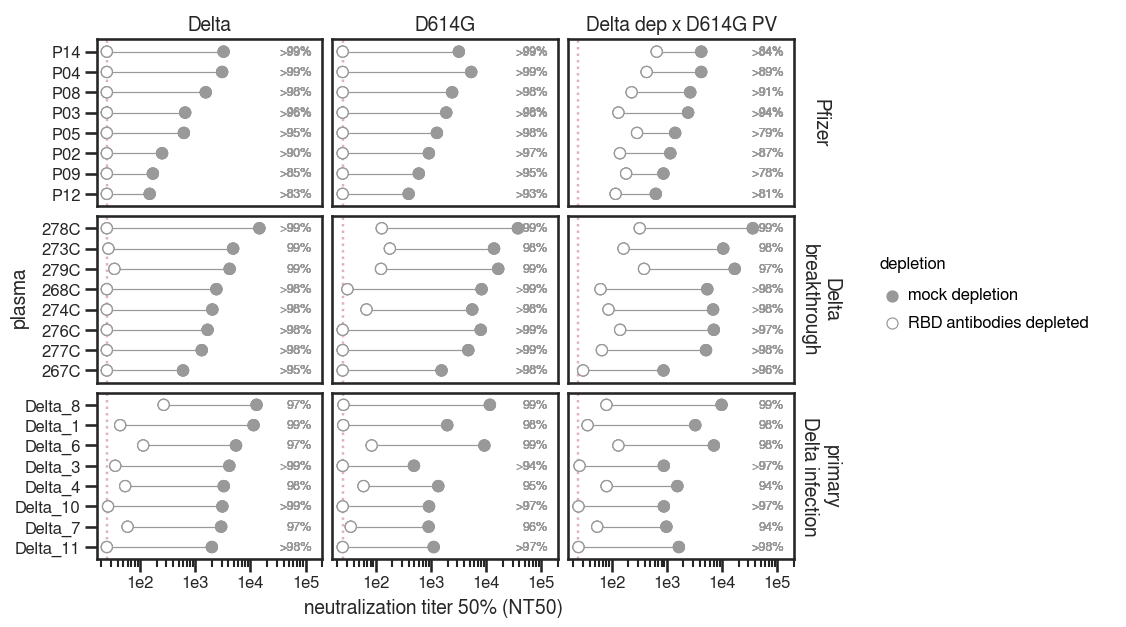

In [11]:


p = (ggplot(foldchange
            .replace({'Delta breakthrough': 'Delta\nbreakthrough',
                      'primary Delta infection': 'primary\nDelta infection',
                     }
                    )
            .assign(
                # options are to either order sera by name or by potency    
                # serum=lambda x: pd.Categorical(x['serum'], natsort.natsorted(x['serum'].unique())[::-1], ordered=True),
                
                # let's try potency for now
                serum=lambda x: pd.Categorical(x['serum'], serum_order, ordered=True),
                spike=lambda x: pd.Categorical (x['spike'], ordered=True, categories=['Delta', 'D614G', 'Delta dep x D614G PV']),
                sample_type=lambda x: pd.Categorical(x['sample_type'], ordered=True, categories=['Pfizer','Delta\nbreakthrough','primary\nDelta infection']))
            , 
            aes(x='NT50',
                y='serum',
                fill='depletion',
                group='serum',
                label='perc_RBD_str',
                # color='sample_type',
               )) +
     scale_x_log10(name='neutralization titer 50% (NT50)', 
                   limits=[config['NT50_LOD'],foldchange['NT50'].max()*3.5]) +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_line(alpha=1, color=CBPALETTE[0]) + #
     geom_point(size=4, color=CBPALETTE[0]) + #
     geom_text(aes(x=foldchange['NT50'].max()*3.5, y='serum'), #
               color=CBPALETTE[0],
               ha='right',
               size=9,
              ) +
     theme(figure_size=(3*foldchange['spike'].nunique(),0.75+0.25*foldchange['serum'].nunique()),
           axis_text=element_text(size=12),
           legend_text=element_text(size=12),
           legend_title=element_text(size=12),
           axis_title_x=element_text(size=14),
           axis_title_y=element_text(size=14, margin={'r': 16}),
           legend_position='right',
           strip_background=element_blank(),
           strip_text=element_text(size=14),
          ) +
     facet_grid('sample_type~spike', scales='free_y' )+
     ylab('plasma') +
     scale_fill_manual(values=['#999999', '#FFFFFF', ]) #+
     # scale_color_manual(values=CBPALETTE[1:]) #+
     # labs(fill = '')
    )

_ = p.draw()

p.save(f'{resultsdir}/NT50_trackplot.pdf')

# save dataframe to CSV
csvfile=f'{resultsdir}/RBD_depletion_NT50.csv'
print(f'Writing to {csvfile}')
foldchange.to_csv(csvfile, index=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_RBDtargeting.pdf


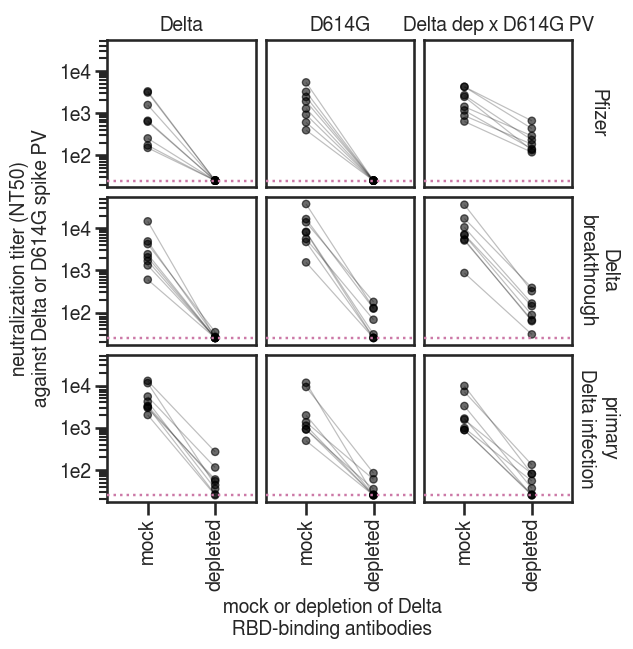

In [12]:
LOD = config['NT50_LOD']

NT50_lines = (ggplot((foldchange
                      .replace({'mock depletion':'mock',
                                'RBD antibodies depleted': 'depleted',
                                'Delta breakthrough': 'Delta\nbreakthrough',
                                'primary Delta infection': 'primary\nDelta infection',
                               }
                              )
                      .assign(spike=lambda x: pd.Categorical (x['spike'], ordered=True, categories=['Delta', 'D614G', 'Delta dep x D614G PV']),
                              sample_type=lambda x: pd.Categorical(x['sample_type'], ordered=True, categories=['Pfizer','Delta\nbreakthrough','primary\nDelta infection']),
                                                                   depletion=lambda x: pd.Categorical(x['depletion'], categories=['mock', 'depleted'], ordered=True))
                     )
                     , aes(x='depletion',
                           y='NT50',
                           group='serum'
                          )
                    ) + 
              geom_point(size=2.5, alpha=0.25) +
              geom_line(alpha=0.25) +
              facet_grid('sample_type~spike') +
              theme(axis_title_y=element_text(margin={'r': 6}),
                    strip_background=element_blank(),
                    figure_size=(6, 6),
                    axis_text_x=element_text(angle=90),
                    text=element_text(size=14),
                   ) +
              scale_y_log10(name='neutralization titer (NT50)\nagainst Delta or D614G spike PV') +
              xlab('mock or depletion of Delta\nRBD-binding antibodies') +
              geom_hline(yintercept=LOD,
                         color=CBPALETTE[7],
                         alpha=1,
                         size=1,
                         linetype='dotted',
                        )
             )

_ = NT50_lines.draw()
NT50_lines.save(f'{resultsdir}/compare_RBDtargeting.pdf')

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 3 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_percentRBD.pdf
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff', '#333333ff'

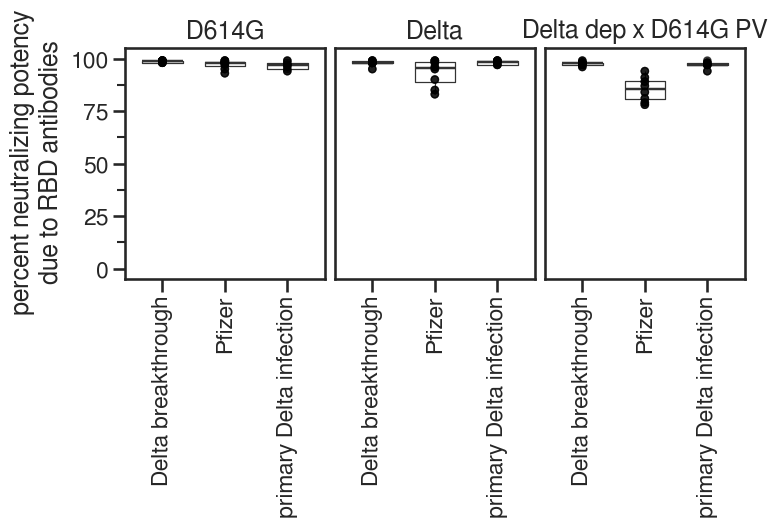

In [13]:
p = (ggplot((foldchange.drop(columns=['depletion', 'NT50']).drop_duplicates())
           ) +
     aes('sample_type', 'percent_RBD') +
     geom_boxplot(width=0.65,
                  position=position_dodge(width=0.7),
                  outlier_shape='') +
     geom_jitter(position=position_dodge(width=0.7),
                 alpha=0.4, size=2.5) +
     theme(figure_size=(4*2, 3),
           strip_background=element_blank(),
           axis_text_x=element_text(angle=90),
           ) +
     facet_wrap('~spike')+
     scale_y_continuous(limits=[0, 100]) +
     ylab('percent neutralizing potency\ndue to RBD antibodies') +
     xlab ('')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_percentRBD.pdf')

In [14]:
stat_test_df = (foldchange
                [['serum', 'sample_type', 'fold_change', 'percent_RBD', 'post_ic50_bound']]
                .drop_duplicates()
               )

print(f"Comparing early 2020 to B.1.351")
percent_1 = stat_test_df.query('sample_type == "Delta breakthrough"')['percent_RBD']
percent_2 = stat_test_df.query('sample_type == "Pfizer"')['percent_RBD']
u, p = scipy.stats.mannwhitneyu(percent_1, percent_2)
print(f"  Mann-Whitney test:      P = {p:.2g}")
res = lifelines.statistics.logrank_test(percent_1, percent_2)
print(f"  Log-rank test:          P = {res.p_value:.2g}")
censored_1 = (~stat_test_df.query('sample_type == "Delta breakthrough"')['post_ic50_bound']).astype(int)
censored_2 = (~stat_test_df.query('sample_type == "Pfizer"')['post_ic50_bound']).astype(int)
res = lifelines.statistics.logrank_test(percent_1, percent_2, censored_1, censored_2)
print(f"  Log-rank test censored: P = {res.p_value:.2g}")
# actually, Cox regression is recommended over log-rank test, see here:
# https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html
cox_df = pd.concat([
        pd.DataFrame({'E': censored_1, 'T': percent_1, 'groupA': 1}),
        pd.DataFrame({'E': censored_2, 'T': percent_2, 'groupA': 0})
        ])
cph = lifelines.CoxPHFitter().fit(cox_df, 'T', 'E')
print(f"  Cox proportional-hazards censored: P = {cph.summary.at['groupA', 'p']:.2g}")

Comparing early 2020 to B.1.351
  Mann-Whitney test:      P = 1.9e-06
  Log-rank test:          P = 1.3e-05
  Log-rank test censored: P = 0.025
  Cox proportional-hazards censored: P = 0.067
